## Winowhy: Multiple Choice

Dataset Source: https://huggingface.co/datasets/tasksource/bigbench/viewer/winowhy/train

#### Import Necessary Libraries

In [1]:
import os, sys, random, ast
os.environ['TOKENIZERS_PARALLELISM']='false'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datasets
from datasets import Dataset, DatasetDict, load_dataset

import torch

from dataclasses import dataclass

import transformers
from transformers import AutoTokenizer, AutoModelForMultipleChoice
from transformers import Trainer, TrainingArguments, set_seed
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy

from typing import Optional, Union

!git lfs install

Git LFS initialized.


#### Display Library Versions

In [17]:
print("Python:".rjust(15), sys.version[0:6])
print("NumPy:".rjust(15), np.__version__)
print("Pandas:".rjust(15), pd.__version__)
print("Torch:".rjust(15), torch.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)

        Python: 3.9.12
         NumPy: 1.25.1
        Pandas: 2.0.3
         Torch: 2.0.1
      Datasets: 2.13.1
  Transformers: 4.26.1


#### Load Dataset & Convert To Pandas DataFrame

In [2]:
data = load_dataset("tasksource/bigbench", "winowhy")

data = data.rename_column("inputs", "context")

data.set_format(type="pandas")

df = data['train'][:]

df = df.dropna(how='all')

df = df.drop_duplicates(subset='context')

df['labels'] = df['targets'].apply(lambda x: x[0])

mc_target_values = ['Correct', 'Incorrect']

df['0'] = df['multiple_choice_targets'].apply(lambda x: mc_target_values[0])
df['1'] = df['multiple_choice_targets'].apply(lambda x: mc_target_values[1])

df['labels'] = df['multiple_choice_scores'].apply(lambda x: 1 if x[0] == 0 else 0)

df = df.drop(columns=["multiple_choice_targets", "idx", "multiple_choice_scores", "targets"])

df

Found cached dataset bigbench (/Users/briandunn/.cache/huggingface/datasets/tasksource___bigbench/winowhy/1.0.0/c5da5ac497141c7435da10444495b8577405d4ed01e524265b144a7063718c0c)


  0%|          | 0/2 [00:00<?, ?it/s]

,context,labels,0,1
0,Please answer the following questions about wh...,1,Correct,Incorrect
1,Please answer the following questions about wh...,1,Correct,Incorrect
2,Please answer the following questions about wh...,1,Correct,Incorrect
3,Please answer the following questions about wh...,1,Correct,Incorrect
4,Please answer the following questions about wh...,1,Correct,Incorrect
...,...,...,...,...
2285,Please answer the following questions about wh...,1,Correct,Incorrect
2286,Please answer the following questions about wh...,0,Correct,Incorrect
2287,Please answer the following questions about wh...,0,Correct,Incorrect
2288,Please answer the following questions about wh...,1,Correct,Incorrect


#### Visual: Word Length of Training Dataset Inputs

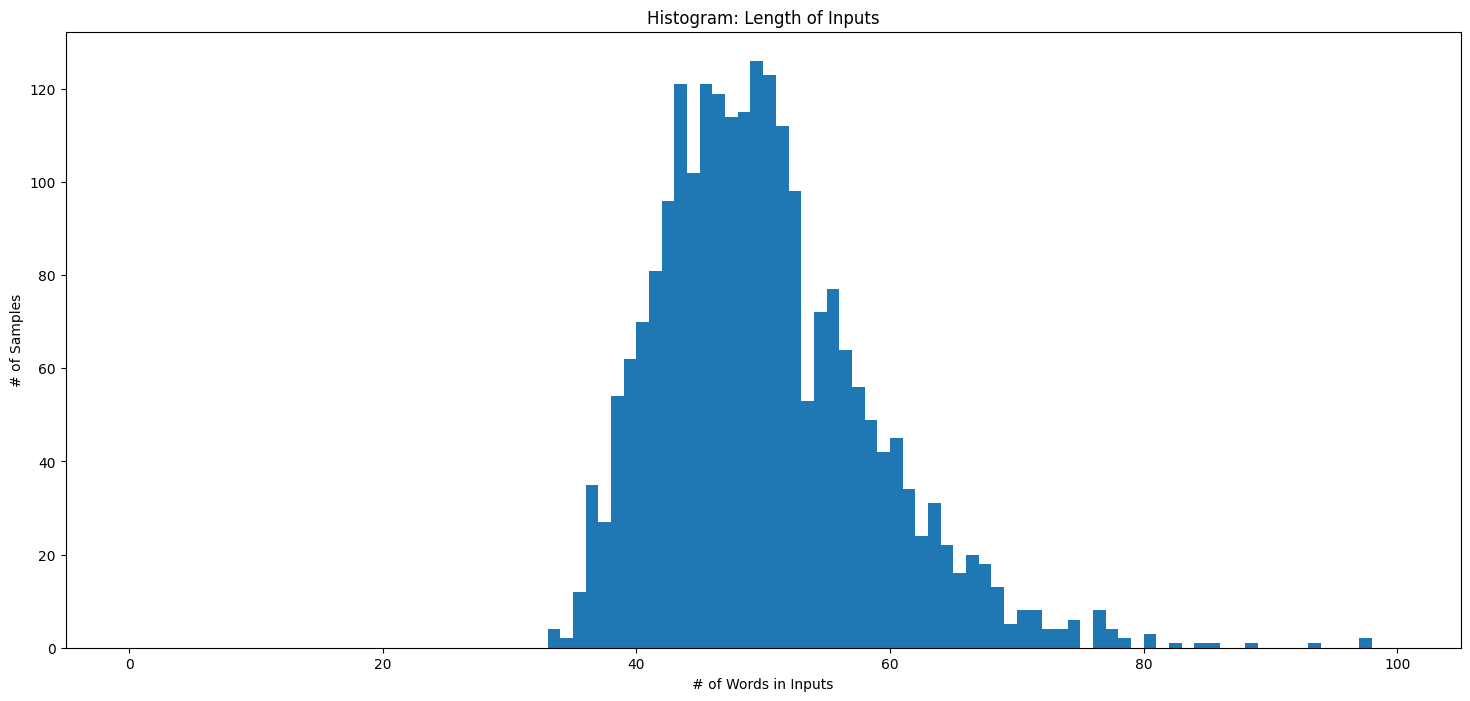

The maximum length of inputs is 97 words.


In [3]:
df['input_length'] = df['context'].str.split().str.len()

n_bin= 100
df.hist('input_length', grid=False, figsize=(18,8), range=(0,n_bin), bins=n_bin)
plt.title('Histogram: Length of Inputs')
plt.xlabel('# of Words in Inputs')
plt.ylabel('# of Samples')
plt.show()

print(f"The maximum length of inputs is {max(df['input_length'])} words.")

df = df.drop(columns=['input_length'])

#### Convert from DataFrame to Dataset & Split into Training/Testing/Evaluation Datasets

In [20]:
dataset = Dataset.from_pandas(df)

train_testeval = dataset.train_test_split(test_size=0.20)
test_eval = train_testeval['test'].train_test_split(test_size=0.50)

ds = DatasetDict({
    'train' : train_testeval['train'],
    'test' : test_eval['train'],
    'eval' : test_eval['test'],
})

print("Training Dataset Shape:", ds['train'].shape)
print("Testing Dataset Shape:", ds['test'].shape)
print("Evaluation Dataset Shape:", ds['eval'].shape)

print(ds['train'].features)

Training Dataset Shape: (1831, 5)
Testing Dataset Shape: (229, 5)
Evaluation Dataset Shape: (229, 5)
{'context': Value(dtype='string', id=None), 'labels': Value(dtype='int64', id=None), '0': Value(dtype='string', id=None), '1': Value(dtype='string', id=None), '__index_level_0__': Value(dtype='int64', id=None)}


#### Display Example

In [21]:
ds['train'][12]

{'context': "Please answer the following questions about which words certain pronouns refer to.\n\nBob was playing cards with Adam and was way ahead. If Adam hadn't had a sudden run of good luck, he would have lost. The 'he' refers to adam because The pronoun refers to Adam and what he would have done.\nThe above reasoning is",
 'labels': 0,
 '0': 'Correct',
 '1': 'Incorrect',
 '__index_level_0__': 306}

#### Create Function to Display an Example Sample

In [22]:
def show_one_example(sample):
    print(f"Context: {sample['context']}")
    print(f"\nGround Truth: {mc_target_values[sample['labels']]}")

#### Display an Example Sample

In [23]:
show_one_example(ds['train'][12])

Context: Please answer the following questions about which words certain pronouns refer to.

Bob was playing cards with Adam and was way ahead. If Adam hadn't had a sudden run of good luck, he would have lost. The 'he' refers to adam because The pronoun refers to Adam and what he would have done.
The above reasoning is

Ground Truth: Correct


#### Basic Values/Constants

In [24]:
MODEL_CKPT = "bert-base-uncased"
MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-Winowhy"

STRATEGY = "epoch"
LEARNING_RATE = 5e-5

BATCH_SIZE = 16
NUM_OF_EPOCHS = 5

WEIGHT_DECAY = 0.01
REPORTS_TO = "tensorboard"

set_seed = 42

#### Instantiate Tokenizer

In [25]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT, 
                                          use_fast=True)

#### Create Preprocessing Function

In [26]:
ending_names = ["0", "1"]

def preprocess_function(samples):
    input_headers = samples["context"]
    input = [[f"{header} {samples[end][i]}" for end in ending_names] for i, header in enumerate(input_headers)]
    
    input = sum(input, [])
    
    tokenized_samples = tokenizer(input, truncation=True)
    
    return {k: [v[i:i + len(ending_names)] for i in range(0, len(v), len(ending_names))] 
            for k, v in tokenized_samples.items()}

#### Apply Preprocessing Function to Dataset

In [27]:
encoded_ds = ds.map(preprocess_function, 
                    batched=True)

Map:   0%|          | 0/1831 [00:00<?, ? examples/s]

Map:   0%|          | 0/229 [00:00<?, ? examples/s]

Map:   0%|          | 0/229 [00:00<?, ? examples/s]

In [28]:
encoded_ds['train'].features

{'context': Value(dtype='string', id=None),
 'labels': Value(dtype='int64', id=None),
 '0': Value(dtype='string', id=None),
 '1': Value(dtype='string', id=None),
 '__index_level_0__': Value(dtype='int64', id=None),
 'input_ids': Sequence(feature=Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), length=-1, id=None)}

#### Instantiate Model

In [29]:
model = AutoModelForMultipleChoice.from_pretrained(MODEL_CKPT)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultipleChoice: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly

#### Define TrainingArguments

In [30]:
args = TrainingArguments(
    output_dir=MODEL_NAME,
    evaluation_strategy=STRATEGY,
    save_strategy=STRATEGY,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_OF_EPOCHS,
    weight_decay=WEIGHT_DECAY,
    report_to=REPORTS_TO,
    logging_first_step=True,
    logging_steps=20,
    load_best_model_at_end=True,
    hub_private_repo=True,
    group_by_length=True,
    push_to_hub=True
)

#### Define Data Collator Class

In [31]:
@dataclass
class DataCollatorForMultipleChoice:
    """
    Data collator that will dynamically pad inputs 
    for the multiple choices received.
    """

    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    
    def __call__(self, features):
        label_name = "label" if "label" in features[0].keys() else "labels"
        labels = [feature.pop(label_name) for feature in features]
        batch_size = len(features)
        num_choices = len(features[0]["input_ids"])
        flattened_features = [[{k: v[i] for k, v in feature.items()} 
                               for i in range(num_choices)] for feature in features]
        flattened_features = sum(flattened_features, [])
        
        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        
        # Unflatten
        batch = {k: v.view(batch_size, 
                           num_choices, 
                           -1)
                 for k, v in batch.items()}
        # Add back labels
        batch["labels"] = torch.tensor(labels, 
                                       dtype=torch.int64)
        return batch

#### Create Function to Compute Metrics

In [32]:
def compute_metrics(predictions):
    preds, labels = predictions
    preds = np.argmax(preds, axis=1)
    return {"accuracy": (preds == labels).astype(np.float32).mean().item()}

#### Instantiate Trainer

In [33]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=encoded_ds["train"],
    eval_dataset=encoded_ds["eval"],
    tokenizer=tokenizer,
    data_collator=DataCollatorForMultipleChoice(tokenizer),
    compute_metrics=compute_metrics,
)

Cloning https://huggingface.co/DunnBC22/bert-base-uncased-Winowhy into local empty directory.


#### Train Model

In [34]:
train_results = trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: __index_level_0__, context, 0, 1. If __index_level_0__, context, 0, 1 are not expected by `BertForMultipleChoice.forward`,  you can safely ignore this message.
/Users/briandunn/Desktop/python_venvs/text_sum/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1831
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 575
  Number of trainable parameters = 109483009


  0%|          | 0/575 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.6713, 'learning_rate': 4.9913043478260876e-05, 'epoch': 0.01}
{'loss': 0.6959, 'learning_rate': 4.8260869565217394e-05, 'epoch': 0.17}
{'loss': 0.6894, 'learning_rate': 4.6521739130434785e-05, 'epoch': 0.35}
{'loss': 0.6905, 'learning_rate': 4.478260869565218e-05, 'epoch': 0.52}
{'loss': 0.6999, 'learning_rate': 4.304347826086957e-05, 'epoch': 0.7}
{'loss': 0.7028, 'learning_rate': 4.130434782608696e-05, 'epoch': 0.87}


The following columns in the evaluation set don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: __index_level_0__, context, 0, 1. If __index_level_0__, context, 0, 1 are not expected by `BertForMultipleChoice.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 229
  Batch size = 16


  0%|          | 0/15 [00:00<?, ?it/s]

Saving model checkpoint to bert-base-uncased-Winowhy/checkpoint-115
Configuration saved in bert-base-uncased-Winowhy/checkpoint-115/config.json


{'eval_loss': 0.6915905475616455, 'eval_accuracy': 0.5371178984642029, 'eval_runtime': 43.0442, 'eval_samples_per_second': 5.32, 'eval_steps_per_second': 0.348, 'epoch': 1.0}


Model weights saved in bert-base-uncased-Winowhy/checkpoint-115/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-Winowhy/checkpoint-115/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Winowhy/checkpoint-115/special_tokens_map.json
tokenizer config file saved in bert-base-uncased-Winowhy/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Winowhy/special_tokens_map.json


{'loss': 0.6928, 'learning_rate': 3.956521739130435e-05, 'epoch': 1.04}
{'loss': 0.6903, 'learning_rate': 3.7826086956521736e-05, 'epoch': 1.22}
{'loss': 0.6207, 'learning_rate': 3.6086956521739134e-05, 'epoch': 1.39}
{'loss': 0.6048, 'learning_rate': 3.4347826086956526e-05, 'epoch': 1.57}
{'loss': 0.5125, 'learning_rate': 3.260869565217392e-05, 'epoch': 1.74}
{'loss': 0.6119, 'learning_rate': 3.086956521739131e-05, 'epoch': 1.91}


The following columns in the evaluation set don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: __index_level_0__, context, 0, 1. If __index_level_0__, context, 0, 1 are not expected by `BertForMultipleChoice.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 229
  Batch size = 16


  0%|          | 0/15 [00:00<?, ?it/s]

Saving model checkpoint to bert-base-uncased-Winowhy/checkpoint-230
Configuration saved in bert-base-uncased-Winowhy/checkpoint-230/config.json


{'eval_loss': 0.5572165846824646, 'eval_accuracy': 0.7030567526817322, 'eval_runtime': 42.0977, 'eval_samples_per_second': 5.44, 'eval_steps_per_second': 0.356, 'epoch': 2.0}


Model weights saved in bert-base-uncased-Winowhy/checkpoint-230/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-Winowhy/checkpoint-230/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Winowhy/checkpoint-230/special_tokens_map.json
tokenizer config file saved in bert-base-uncased-Winowhy/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Winowhy/special_tokens_map.json


{'loss': 0.5301, 'learning_rate': 2.9130434782608696e-05, 'epoch': 2.09}
{'loss': 0.4385, 'learning_rate': 2.7391304347826085e-05, 'epoch': 2.26}
{'loss': 0.5125, 'learning_rate': 2.5652173913043483e-05, 'epoch': 2.43}
{'loss': 0.5065, 'learning_rate': 2.391304347826087e-05, 'epoch': 2.61}
{'loss': 0.4039, 'learning_rate': 2.2173913043478262e-05, 'epoch': 2.78}
{'loss': 0.4959, 'learning_rate': 2.0434782608695654e-05, 'epoch': 2.96}


The following columns in the evaluation set don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: __index_level_0__, context, 0, 1. If __index_level_0__, context, 0, 1 are not expected by `BertForMultipleChoice.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 229
  Batch size = 16


  0%|          | 0/15 [00:00<?, ?it/s]

Saving model checkpoint to bert-base-uncased-Winowhy/checkpoint-345
Configuration saved in bert-base-uncased-Winowhy/checkpoint-345/config.json


{'eval_loss': 0.5327908992767334, 'eval_accuracy': 0.7117903828620911, 'eval_runtime': 45.104, 'eval_samples_per_second': 5.077, 'eval_steps_per_second': 0.333, 'epoch': 3.0}


Model weights saved in bert-base-uncased-Winowhy/checkpoint-345/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-Winowhy/checkpoint-345/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Winowhy/checkpoint-345/special_tokens_map.json
tokenizer config file saved in bert-base-uncased-Winowhy/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Winowhy/special_tokens_map.json


{'loss': 0.3864, 'learning_rate': 1.8695652173913045e-05, 'epoch': 3.13}
{'loss': 0.4216, 'learning_rate': 1.6956521739130433e-05, 'epoch': 3.3}
{'loss': 0.3987, 'learning_rate': 1.5217391304347828e-05, 'epoch': 3.48}
{'loss': 0.3078, 'learning_rate': 1.3478260869565218e-05, 'epoch': 3.65}
{'loss': 0.3576, 'learning_rate': 1.173913043478261e-05, 'epoch': 3.83}


The following columns in the evaluation set don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: __index_level_0__, context, 0, 1. If __index_level_0__, context, 0, 1 are not expected by `BertForMultipleChoice.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 229
  Batch size = 16


{'loss': 0.4537, 'learning_rate': 1e-05, 'epoch': 4.0}


  0%|          | 0/15 [00:00<?, ?it/s]

Saving model checkpoint to bert-base-uncased-Winowhy/checkpoint-460
Configuration saved in bert-base-uncased-Winowhy/checkpoint-460/config.json


{'eval_loss': 0.582892656326294, 'eval_accuracy': 0.7117903828620911, 'eval_runtime': 45.5169, 'eval_samples_per_second': 5.031, 'eval_steps_per_second': 0.33, 'epoch': 4.0}


Model weights saved in bert-base-uncased-Winowhy/checkpoint-460/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-Winowhy/checkpoint-460/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Winowhy/checkpoint-460/special_tokens_map.json
tokenizer config file saved in bert-base-uncased-Winowhy/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Winowhy/special_tokens_map.json


{'loss': 0.2967, 'learning_rate': 8.26086956521739e-06, 'epoch': 4.17}
{'loss': 0.3049, 'learning_rate': 6.521739130434783e-06, 'epoch': 4.35}
{'loss': 0.2624, 'learning_rate': 4.782608695652174e-06, 'epoch': 4.52}
{'loss': 0.2535, 'learning_rate': 3.0434782608695654e-06, 'epoch': 4.7}
{'loss': 0.2275, 'learning_rate': 1.3043478260869564e-06, 'epoch': 4.87}


The following columns in the evaluation set don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: __index_level_0__, context, 0, 1. If __index_level_0__, context, 0, 1 are not expected by `BertForMultipleChoice.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 229
  Batch size = 16


  0%|          | 0/15 [00:00<?, ?it/s]

Saving model checkpoint to bert-base-uncased-Winowhy/checkpoint-575
Configuration saved in bert-base-uncased-Winowhy/checkpoint-575/config.json


{'eval_loss': 0.800542950630188, 'eval_accuracy': 0.7117903828620911, 'eval_runtime': 41.7495, 'eval_samples_per_second': 5.485, 'eval_steps_per_second': 0.359, 'epoch': 5.0}


Model weights saved in bert-base-uncased-Winowhy/checkpoint-575/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-Winowhy/checkpoint-575/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Winowhy/checkpoint-575/special_tokens_map.json
tokenizer config file saved in bert-base-uncased-Winowhy/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Winowhy/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from bert-base-uncased-Winowhy/checkpoint-345 (score: 0.5327908992767334).


{'train_runtime': 5591.5046, 'train_samples_per_second': 1.637, 'train_steps_per_second': 0.103, 'train_loss': 0.4877418389527694, 'epoch': 5.0}


#### Push to HuggingFace Hub

In [35]:
trainer.push_to_hub()

Saving model checkpoint to bert-base-uncased-Winowhy
Configuration saved in bert-base-uncased-Winowhy/config.json
Model weights saved in bert-base-uncased-Winowhy/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-Winowhy/tokenizer_config.json
Special tokens file saved in bert-base-uncased-Winowhy/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/418M [00:00<?, ?B/s]

Upload file runs/Aug01_17-20-14_Brians-Mac-mini/events.out.tfevents.1690928419.Brians-Mac-mini.33655.0:   0%| …

To https://huggingface.co/DunnBC22/bert-base-uncased-Winowhy
   1ed9e7f..5ae2623  main -> main

Dropping the following result as it does not have all the necessary fields:
{'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.7117903828620911}]}
To https://huggingface.co/DunnBC22/bert-base-uncased-Winowhy
   5ae2623..e802a1d  main -> main



'https://huggingface.co/DunnBC22/bert-base-uncased-Winowhy/commit/5ae2623f884d0a859d99aec80d36c7966584c6fe'

#### Evaluate Model

In [36]:
metrics = trainer.evaluate()

print(metrics)

The following columns in the evaluation set don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: __index_level_0__, context, 0, 1. If __index_level_0__, context, 0, 1 are not expected by `BertForMultipleChoice.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 229
  Batch size = 16


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 0.5327908992767334, 'eval_accuracy': 0.7117903828620911, 'eval_runtime': 42.2959, 'eval_samples_per_second': 5.414, 'eval_steps_per_second': 0.355, 'epoch': 5.0}


### Notes & Other Takeaways From This Project
****
- I am glad that I had the best version saved. If I did not, it would have returned an overtrained/overfitted model.

****

#### Citation
- Model Checkpoint
    > @article{DBLP:journals/corr/abs-1810-04805, author = {Jacob Devlin and Ming{-}Wei Chang and Kenton Lee and Kristina Toutanova}, title = {{BERT:} Pre-training of Deep Bidirectional Transformers for Language Understanding}, journal = {CoRR}, volume = {abs/1810.04805}, year = {2018}, url = {http://arxiv.org/abs/1810.04805%7D, archivePrefix = {arXiv}, eprint = {1810.04805}, timestamp = {Tue, 30 Oct 2018 20:39:56 +0100}, biburl = {https://dblp.org/rec/journals/corr/abs-1810-04805.bib%7D, bibsource = {dblp computer science bibliography, https://dblp.org%7D}